In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
path ="/content/drive/MyDrive/DatasetClientClustering.csv"
# path = 'DatasetClientClustering.csv'
dataset = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**CONTESTO**

Azienda di Data Analytics specializzata in Machine Learning, AI ed Investment Strategy. Commissione di Wealth Management: gestione degli investimenti delle persone.

5000 persone di diversa Età

**OBIETTIVI**

Caratteristiche d’Investimento
*   Statistiche Descrittive



Segmentazione dei Clienti

*   Cluster Analysis
*   Similaritò - Dissimilarità




Abbinamento


*   Cliente ↔ Investimenti


**Pre-processing**



*   Ricodifica Variabili Categoriali
*   Provincia NA (Napoli)


*   Normalizzazione Variabili e PCA
*   One Hot Encoding








**Eliminate**




*   Provincia
*   Sesso
*   Inizio Rapporto con il Cliente
*   Fiducia nelle banche



**ANALISI ESPLORATIVA**

In [ ]:
dataset.columns

Index(['ClientID', 'RiskPropension', 'PortfolioRisk',
       'ClientInvestmentHorizon', 'PortfolioHorizon',
       'ClientKnowledgeExperience', 'ClientPotentialIndex', 'IncomeHighLow',
       'Sex', 'AuM', 'Age', 'IncomeNeed', 'LongTermCareNeed', 'ProtectionNeed',
       'PensionNeed', 'InheritanceIndex', 'PanicMood', 'ClientDateStart',
       'NoTrustInBanks', 'Prov', 'BondInvestments', 'EquityInvestments',
       'MoneyMarketInvestments', 'OtherInvestments', 'Cash'],
      dtype='object')

In [ ]:
dataset.head()
dataset_original=dataset.copy()
dataset=dataset[['RiskPropension', 'PortfolioRisk',
       'ClientInvestmentHorizon', 'PortfolioHorizon',
       'ClientKnowledgeExperience', 'ClientPotentialIndex', 'IncomeHighLow',
       'AuM', 'Age', 'IncomeNeed', 'LongTermCareNeed', 'ProtectionNeed',
       'PensionNeed', 'InheritanceIndex', 'PanicMood',
       'BondInvestments', 'EquityInvestments',
       'MoneyMarketInvestments', 'OtherInvestments', 'Cash']]

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,IncomeHighLow,AuM,Age,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex,PanicMood,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash
mean,0.488939,0.047734,12.536004,2.340548,0.619686,0.256095,0.078400,1.898872e+05,54.575400,0.338791,0.476238,0.376164,0.417580,0.484838,-0.013200,0.498821,0.230302,0.047452,0.040530,0.174540
std,0.130907,0.047463,8.178925,1.836560,0.164812,0.174461,0.268827,5.234644e+05,17.574325,0.188517,0.259825,0.211200,0.239535,0.199010,0.114142,0.274451,0.198136,0.094192,0.087306,0.303692
min,0.031131,0.000000,0.676500,0.500000,0.047619,0.000000,0.000000,1.000000e+04,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.388924,0.026103,6.970000,1.078800,0.523810,0.128834,0.000000,2.773650e+04,43.000000,0.215574,0.221779,0.216692,0.145318,0.385020,0.000000,0.329475,0.066875,0.000000,0.000000,0.001500
50%,0.476067,0.042425,10.207220,2.000000,0.619048,0.216564,0.000000,6.696500e+04,54.000000,0.299619,0.476906,0.296553,0.507460,0.519600,0.000000,0.533350,0.199150,0.023100,0.000000,0.026900
75%,0.581871,0.059148,15.788751,3.203675,0.714286,0.350307,0.000000,1.639182e+05,68.000000,0.394999,0.747571,0.616763,0.609014,0.629046,0.000000,0.694300,0.348025,0.058000,0.046350,0.159975
max,1.000000,1.000000,73.424345,40.330173,1.000000,0.906748,1.000000,1.436670e+07,103.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Analisi delle Variabili e Divisione in 2
sfere di interesse: **Investment; Profile**
**Near Zero Variance**: Panic Mood
**No Valori Mancanti**: Correlazione; Outliers

In [ ]:
dataset['PanicMood']=dataset['PanicMood'].astype(str)
dataset['PanicMood']=dataset['PanicMood'].str.replace('-1','1')
dataset['PanicMood']=dataset['PanicMood'].astype(int)


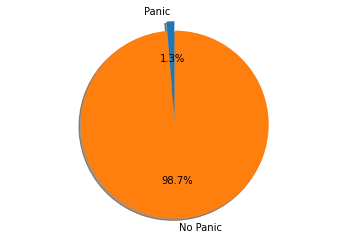

In [ ]:
labels = 'Panic', 'No Panic'
sizes = [66, 4934]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
dataset.drop(columns=['IncomeHighLow','AuM','PanicMood'], inplace=True)


KeyError: ignored

**Correlazione**

Matrice di correlazione incrociata tra variabili relative agli investimenti e variabili relative ai profili dei clienti

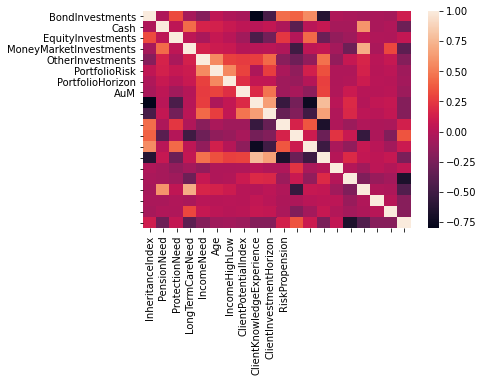

In [ ]:
import seaborn as sns
corr = dataset.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            xticklabels=corr[['InheritanceIndex','PensionNeed', 'ProtectionNeed', 'LongTermCareNeed', 'IncomeNeed',   
                              'Age',  'IncomeHighLow', 'ClientPotentialIndex',  'ClientKnowledgeExperience',  
                              'ClientInvestmentHorizon','RiskPropension']],
            yticklabels=corr[[ 'BondInvestments', 'Cash','EquityInvestments', 'MoneyMarketInvestments',  'OtherInvestments', 
                               'PortfolioRisk', 'PortfolioHorizon', 'AuM']])



In [ ]:
description=dataset[[ 'BondInvestments', 'Cash','EquityInvestments', 'MoneyMarketInvestments',  'OtherInvestments', 
                               'PortfolioRisk', 'PortfolioHorizon']].describe(include='all')  
description
description.drop(labels=['count'])

,BondInvestments,Cash,EquityInvestments,MoneyMarketInvestments,OtherInvestments,PortfolioRisk,PortfolioHorizon
mean,0.498821,0.174540,0.230302,0.047452,0.040530,0.047734,2.340548
std,0.274451,0.303692,0.198136,0.094192,0.087306,0.047463,1.836560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
25%,0.329475,0.001500,0.066875,0.000000,0.000000,0.026103,1.078800
50%,0.533350,0.026900,0.199150,0.023100,0.000000,0.042425,2.000000
75%,0.694300,0.159975,0.348025,0.058000,0.046350,0.059148,3.203675
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.330173


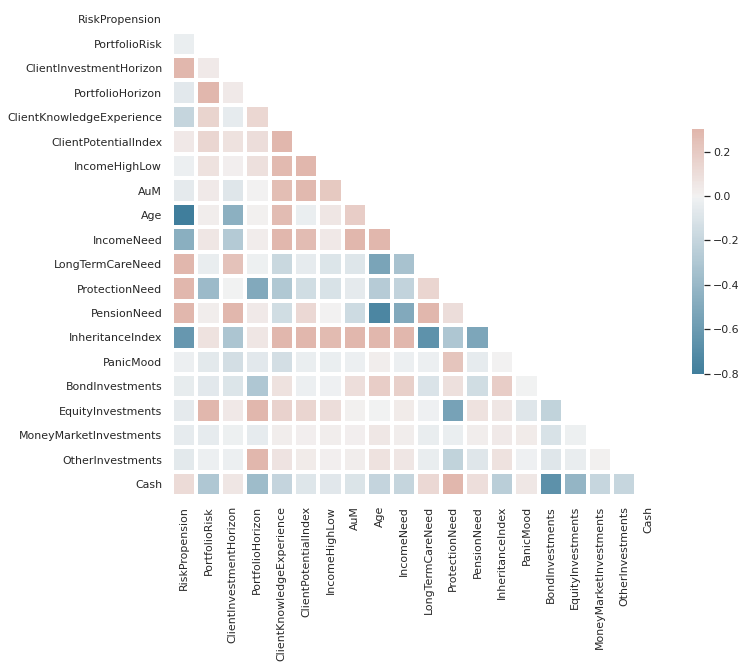

In [ ]:
from string import ascii_letters

sns.set_theme(style="white")


# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=3, cbar_kws={"shrink": .5})

Clustering


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = dataset.values
X = sc.fit_transform(X)
X
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

X

array([[-3.15014656,  2.26331284],
       [ 0.50945354,  1.14423787],
       [-4.48628876, -1.44822421],
       ...,
       [-2.94305084, -2.03739269],
       [ 0.78855225, -1.39562283],
       [-2.30346981,  2.1220201 ]])

Elbow

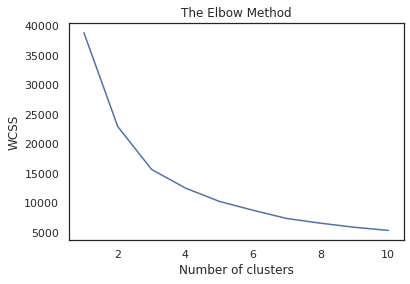

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init=10, max_iter=10000, random_state = 1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Silhouette

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
range_n_clusters=[2,3,4,5,6,7,8,9]
for n_clusters in range_n_clusters:
  clusterer=KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels=clusterer.fit_predict(X)
  # the silhouette score gives the avg value for all the samples.
  # this gives a perspective into the density and separation of the formed clusters
  silhouette_avg=silhouette_score(X, cluster_labels)
  print( "for n_clusters =", n_clusters,"The average silhouette_score is:", silhouette_avg)
  # compute the silhouette score for each sample
  sample_silhouette_values=silhouette_samples(X, cluster_labels)

for n_clusters = 2 The average silhouette_score is: 0.3688452005894283
for n_clusters = 3 The average silhouette_score is: 0.37307712973266216
for n_clusters = 4 The average silhouette_score is: 0.34440992717517205
for n_clusters = 5 The average silhouette_score is: 0.3506482752803303
for n_clusters = 6 The average silhouette_score is: 0.3422398258420592
for n_clusters = 7 The average silhouette_score is: 0.3530037121830924
for n_clusters = 8 The average silhouette_score is: 0.34770223043786874
for n_clusters = 9 The average silhouette_score is: 0.3488066055034869


K-means

In [ ]:
km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, max_iter=30000, 
    tol=1e-04, random_state=42
)
y_km = km.fit_predict(X)
labels = km.labels_

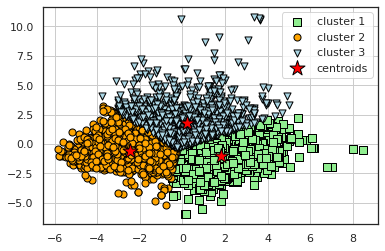

In [ ]:
# plot the 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
      X[y_km == 2, 0], X[y_km == 2, 1],
      s=50, c='lightblue',
      marker='v', edgecolor='black',
      label='cluster 3'  
)

# plt.scatter(
#       X[y_km == 3, 0], X[y_km == 3, 1],
#       s=50, c='lightblue',
#       marker='v', edgecolor='blue',
#       label='cluster 3'  
# )


# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
labels = km.labels_
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X, labels)

0.936132295339147

In [ ]:
Data_clustered_1 = dataset.loc[:, ['RiskPropension', 'PortfolioRisk',
       'ClientInvestmentHorizon', 'PortfolioHorizon',
       'ClientKnowledgeExperience', 'ClientPotentialIndex', 'IncomeHighLow',
       'AuM', 'Age', 'IncomeNeed', 'LongTermCareNeed', 'ProtectionNeed',
       'PensionNeed', 'InheritanceIndex', 'PanicMood',
       'BondInvestments', 'EquityInvestments',
       'MoneyMarketInvestments', 'OtherInvestments', 'Cash']]
Data_clustered_1['Cluster'] = pd.Series(y_km, index=Data_clustered_1.index)
Data_clustered_1.head(10)

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,IncomeHighLow,AuM,Age,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex,PanicMood,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash,Cluster
0,0.597553,0.087787,20.778831,3.7027,0.285714,0.148466,0,13719,22,0.079215,0.797512,0.204401,0.633762,0.114803,0,0.5730,0.4270,0.0000,0.0000,0.0000,1
1,0.501486,0.062290,15.228477,2.7327,0.714286,0.152761,0,45973,61,0.281602,0.174660,0.153599,0.629258,0.505362,0,0.5341,0.4466,0.0124,0.0000,0.0070,2
2,0.554108,0.000000,9.675789,0.5000,0.523810,0.243558,0,10233,24,0.124015,0.882995,0.769608,0.663677,0.069924,0,0.0000,0.0000,0.0000,0.0000,1.0000,1
3,0.440729,0.032341,9.563829,2.5676,0.619048,0.089571,0,25144,46,0.209610,0.548211,0.226218,0.218019,0.415670,0,0.6428,0.1220,0.0407,0.1943,0.0002,2
4,0.540528,0.037852,17.941533,2.4911,0.428571,0.162577,0,222892,57,0.320086,0.907644,0.703936,0.506315,0.335057,0,0.1707,0.2701,0.5332,0.0045,0.0215,1
5,0.565080,0.053811,13.612145,2.0155,0.619048,0.279755,0,34746,50,0.281613,0.185409,0.690448,0.238968,0.502123,0,0.5243,0.2488,0.0000,0.0000,0.2269,1
6,0.582234,0.057505,15.601864,2.5035,0.619048,0.372393,0,313942,53,0.604598,0.215108,0.647779,0.620519,0.638439,0,0.5816,0.3049,0.0714,0.0421,0.0000,2
7,0.337518,0.006087,3.750000,2.8892,0.523810,0.106135,0,124883,80,0.469229,0.218888,0.431528,0.047210,0.666763,0,0.0000,0.0000,0.5587,0.3186,0.1228,0
8,0.323620,0.000000,4.170000,0.5000,0.904762,0.400000,0,75549,91,0.442147,0.228425,0.475744,0.112117,0.762881,0,0.0000,0.0000,0.0000,0.0000,1.0000,0
9,0.557302,0.021440,9.309025,1.2470,0.428571,0.074847,0,25948,52,0.214093,0.514127,0.707950,0.541626,0.488134,0,0.6743,0.1833,0.1259,0.0000,0.0166,1


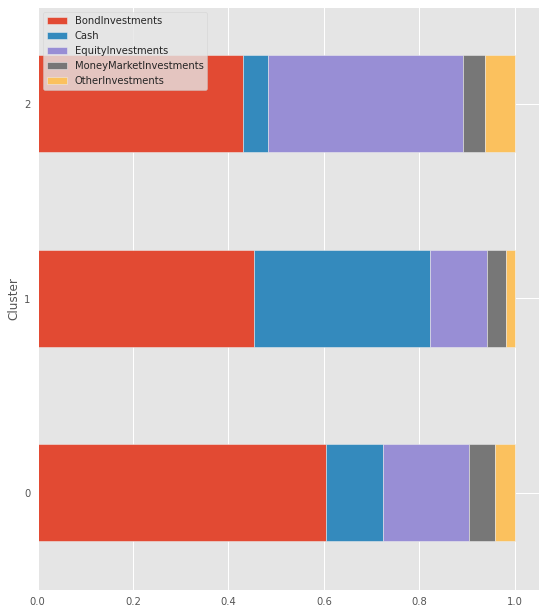

In [ ]:
from sklearn import preprocessing

data_clustered_2 = Data_clustered_1[[ 'BondInvestments', 'Cash','EquityInvestments', 'MoneyMarketInvestments',  'OtherInvestments', 
                               'Cluster']]
plt.style.use('ggplot')
plt.rc('figure', figsize = (8,10))

data12 = data_clustered_2.groupby('Cluster').mean()
data12 = data12.T
data12 = data12/data12.sum()
data12 = data12.T
data12.head()

data12.plot.barh(stacked=True)
plt.show()

In [ ]:
data_clustered_2.groupby('Cluster').mean().head()

,BondInvestments,Cash,EquityInvestments,MoneyMarketInvestments,OtherInvestments
Cluster,,,,,
0,0.601066,0.118605,0.179506,0.054589,0.041592
1,0.451576,0.369224,0.117979,0.041301,0.017501
2,0.423134,0.051699,0.400004,0.044946,0.061668


Hierarchical Clustering (using Ward method)

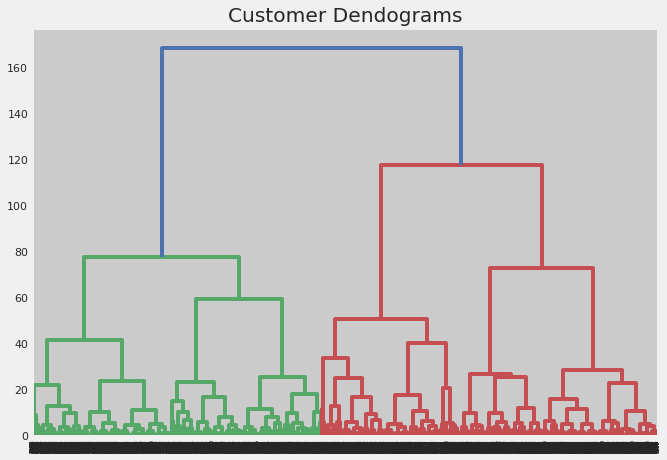

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

In [ ]:
labels = hc.labels_
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X, labels)

0.9811548912411944

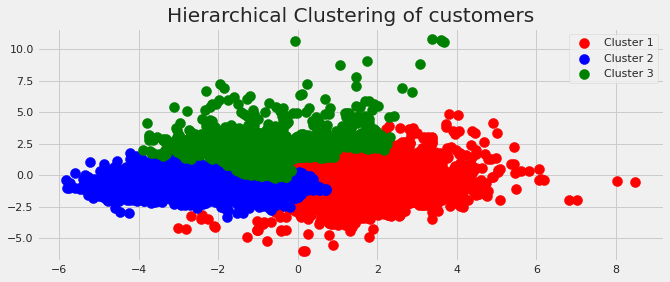

In [ ]:
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
#plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.title('Hierarchical Clustering of customers')
plt.legend()
plt.show()

Violin plot

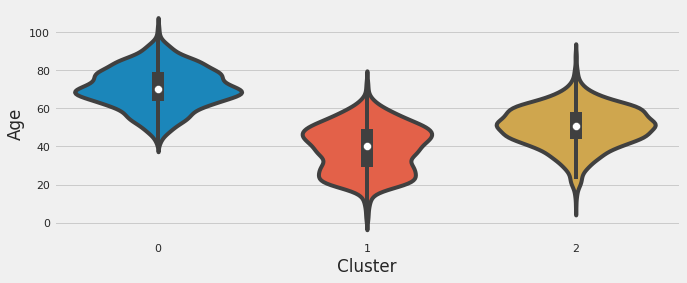

In [ ]:
sns.violinplot(x=Data_clustered_1.Cluster, y=Data_clustered_1.Age)
plt.show()

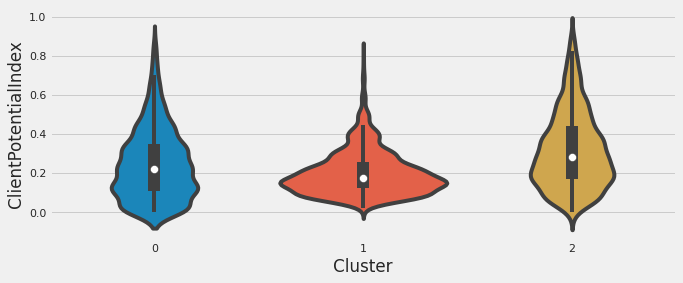

In [ ]:
sns.violinplot(x=Data_clustered_1.Cluster, y=Data_clustered_1.ClientPotentialIndex)
plt.show()

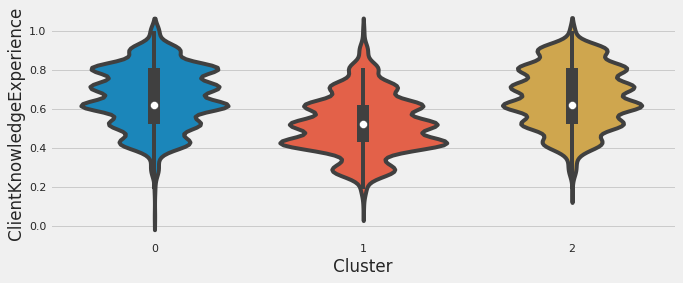

In [ ]:
sns.violinplot(x=Data_clustered_1.Cluster, y=Data_clustered_1.ClientKnowledgeExperience)
plt.show()

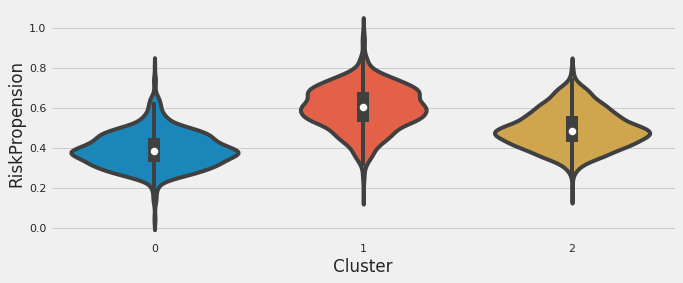

In [ ]:
sns.violinplot(x=Data_clustered_1.Cluster, y=Data_clustered_1.RiskPropension)
plt.show()

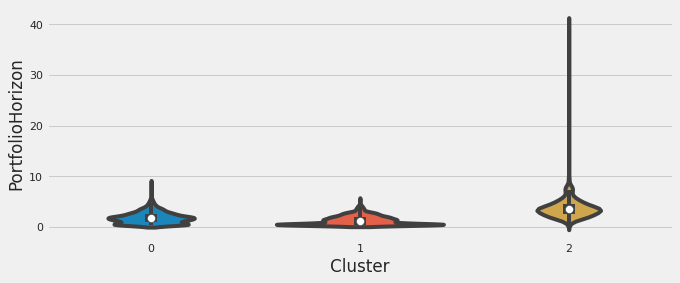

In [ ]:
sns.violinplot(x=Data_clustered_1.Cluster, y=Data_clustered_1.PortfolioHorizon)
plt.show()

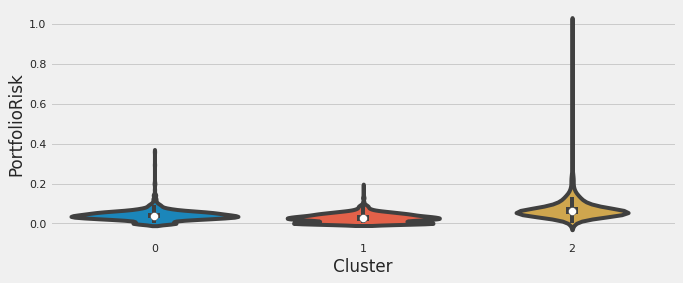

In [ ]:
sns.violinplot(x=Data_clustered_1.Cluster, y=Data_clustered_1.PortfolioRisk)
plt.show()